In [1]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *
import numpy as np
import math

from IPython.display import Image
from IPython.core.display import HTML

# Define Process Parameters

In [2]:
data_dir = "/Users/phivri/Documents/GitHub/Biosustain/MoGeoCoCult"

In [3]:
R = 8.314 # [m^3*Pa/K/mol]

#Temperature range:
T0 = 273.15
T = np.arange(T0, T0+80+1, 1)

def Kelvin_Celsius(t):
    """
    This function converts Temperature values from Kelvin to degrees Celsius
    """
    return t-273.15

def Celsius_Kelvin(t):
    """
    This function converts Temperature values from degrees Celsius to Kelvin
    """
    return t+273.15

# Biological Parameters Acetogen

### Energy Requirements for Growth and Overall Stoichiometry
\[REF] Heijnen J.J. (2010) Impact of Thermodynamic Principles in Systems Biology. In: Wittmann C., Krull R. (eds) Biosystems Engineering II. Advances in Biochemical Engineering / Biotechnology, vol 121. Springer, Berlin, Heidelberg. https://doi.org/10.1007/10_2009_63

In [4]:
a_G = 1000 #kJ/CmolX
print("a_G =", a_G, "[kJ/CmolX]")

a_G = 1000 [kJ/CmolX]


### Energy Requirements for Maintenance

\[REF]: L. Tijhuis, M.C. M. van Loosdrecht, and J. J. Heijnen, A Thermodynamically Based Correlation for Maintenance Gibbs Energy Requirements in Aerobic and Anaerobic Chemotrophic Growth 

m_G(300) = 1.25 [kJ/h/CmolX]


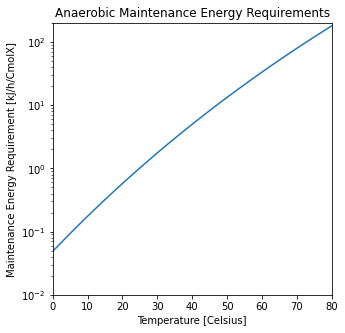

In [12]:
def m_G(T):
    return 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]

print("m_G(300) =", round(m_G(300),2), "[kJ/h/CmolX]")

plt.figure(figsize=(5,5))
plt.title(f"Anaerobic Maintenance Energy Requirements")
plt.axis([0, 80, 0.01, 200])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Maintenance Energy Requirement [kJ/h/CmolX]')
plt.yscale('log')
plt.plot(Kelvin_Celsius(T), m_G(T))

# Calculate Gibbs Free Energy and Enthalpy

<p>Given the reaction stoichiometries:</p>
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O $</p>
<p>$ -4 CO - 2 H_2O + CH_3COOH + 2 CO_2 $</p>

Gibbs energy:
  DrG0_carb = -155.7 [kJ/mol]
  DrG0_hom = -75.3 [kJ/mol]

Enthalpy:
  DrH0_carb = -258.7 [kJ/mol]
  DrH0_hom = -266.3 [kJ/mol]

Temperature corrected Gibbs energy:
  DrGT_carb = -155.1 [kJ/mol]
  DrGT_hom = -74.1 [kJ/mol]


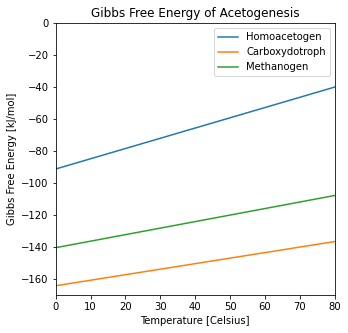

In [13]:
#Gibbs energy of Formation at 298.15
DfG0_actn = -159.7 #[kJ/mol]
DfG0_actt = -389.9 #[kJ/mol]
DfG0_co2 = -394.4 #[kJ/mol]
DfG0_co = -137.2 #[kJ/mol]
DfG0_h2o = -237.1 #[kJ/mol]
DfG0_h2 = 0 #[kJ/mol]
DfG0_ch4 = -50.53 #[kJ/mol]

#standard molar enthalpy
DfH0_actn = -249.4 #[KJ/mol]
DfH0_actt = -483.5 #[KJ/mol]
DfH0_co2 = -394.4 #[KJ/mol]
DfH0_co = -110.5 #[KJ/mol]
DfH0_h2o = -285.8 #[KJ/mol]
DfH0_h2 = 0 #[KJ/mol]
DfH0_ch4 = -74.8 #[KJ/mol]

#Hess's law:
DrG0_carb = -4*DfG0_co - 2*DfG0_h2o + DfG0_actt + 2*DfG0_co2
DrG0_hom = -4*DfG0_h2 - 2*DfG0_co2 + DfG0_actt + 2*DfG0_h2o
DrG0_met = -1*DfG0_co2 - 4*DfG0_h2 + DfG0_ch4 + 2*DfG0_h2o

print("Gibbs energy:\n",
      " DrG0_carb =",round(DrG0_carb,1),"[kJ/mol]\n",
      " DrG0_hom =",round(DrG0_hom,1),"[kJ/mol]\n")

DrH0_carb = -4*DfH0_co - 2*DfH0_h2o + DfH0_actt + 2*DfH0_co2
DrH0_hom = -4*DfH0_h2 - 2*DfH0_co2 + DfH0_actt + 2*DfH0_h2o
DrH0_met = -1*DfH0_co2 - 4*DfH0_h2 + DfH0_ch4 + 2*DfH0_h2o

print("Enthalpy:\n",
      " DrH0_carb =", round(DrH0_carb,1),"[kJ/mol]\n",
      " DrH0_hom =", round(DrH0_hom,1),"[kJ/mol]\n")

#Gibbs–Helmholtz equation for temperature correction
def DrGT_carb(T):
    return DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
def DrGT_hom(T):
    return DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)
def DrGT_met(T):
    return DrG0_met * (T/298.15) + DrH0_met * (1-T/298.15)

print("Temperature corrected Gibbs energy:\n",
      " DrGT_carb =",round(DrGT_carb(300),1),"[kJ/mol]\n",
      " DrGT_hom =",round(DrGT_hom(300),1),"[kJ/mol]")

#dropped concentration correction, in accordance with book

plt.figure(figsize=(5,5))
plt.title(f"Gibbs Free Energy of Acetogenesis")
plt.axis([0, 80, -170, 0])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Gibbs Free Energy [kJ/mol]')
plt.plot(Kelvin_Celsius(T), DrGT_hom(T))
plt.plot(Kelvin_Celsius(T), DrGT_carb(T))
plt.plot(Kelvin_Celsius(T), DrGT_met(T))
plt.legend(['Homoacetogen','Carboxydotroph','Methanogen'])


<p>Given the reaction stoichiometries:</p>

<p>Homoacetogenic</p>
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O = 0$</p>
<p>$ -CO_2 - 2.1 H_2 - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O = 0$ </p>
<p>Carboxydotrophic</p>
<p>$ -4 CO - 2 H_2O + CH_3COOH + 2 CO_2 = 0$</p>
<p>$ -2.1 CO - 0.6 H_2O - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2 = 0$</p>
<p>Methanogenic</p>
<p>$ -CO2 - 4 H_2 + CH_4 + 2 H_2O = 0$</p>




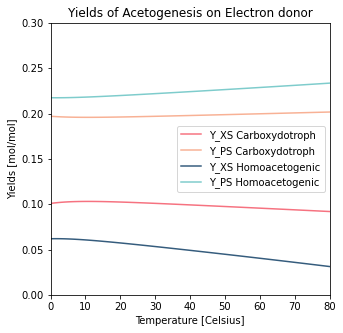

In [14]:
µ = 0.3 #[/h]

a_G = 1000 #kJ/CmolX


def R_X(T):
    return 1 + T*0

def R_CO_carb(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_carb = DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
    return -4 * (-(m_G+a_G*µ)/DrGT_carb) -2.1

def R_actt_carb(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_carb = DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
    return -(m_G+a_G*µ)/DrGT_carb

def R_CO_hom(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_hom = DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)
    return -4 * (-(m_G+a_G*µ)/DrGT_hom) -2.1

def R_actt_hom(T):
    m_G = 0.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
    DrGT_hom = DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)
    return -(m_G+a_G*µ)/DrGT_hom

plt.figure(figsize=(5,5))
plt.title(f"Yields of Acetogenesis on Electron donor")
plt.axis([0, 80, 0, 0.3])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Yields [mol/mol]')
plt.plot(Kelvin_Celsius(T), -R_X(T)/R_CO_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), -R_actt_carb(T)/R_CO_carb(T), color='#F8B195')
plt.plot(Kelvin_Celsius(T), -R_X(T)/R_CO_hom(T), color='#355C7D')
plt.plot(Kelvin_Celsius(T), -R_actt_hom(T)/R_CO_hom(T), color='#7ECCCC')
plt.legend(['Y_XS Carboxydotroph','Y_PS Carboxydotroph','Y_XS Homoacetogenic','Y_PS Homoacetogenic'])

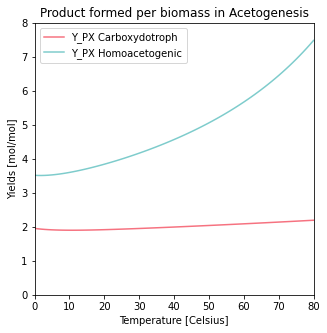

In [11]:
µ = 0.3 #[/h]

a_G = 1000 #kJ/CmolX

plt.figure(figsize=(5,5))
plt.title(f"Product formed per biomass in Acetogenesis")
plt.axis([0, 80, 0, 8])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Yields [mol/mol]')
plt.plot(Kelvin_Celsius(T), R_actt_carb(T)/R_X(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), R_actt_hom(T)/R_X(T), color='#7ECCCC')

plt.legend(['Y_PX Carboxydotroph','Y_PX Homoacetogenic'])

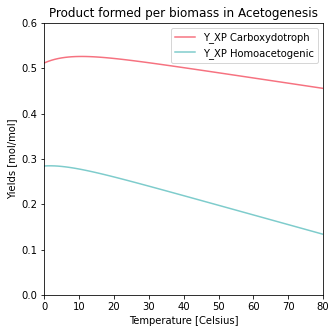

In [10]:
µ = 0.3 #[/h]

a_G = 1000 #kJ/CmolX

plt.figure(figsize=(5,5))
plt.title(f"Product formed per biomass in Acetogenesis")
plt.axis([0, 80, 0, 0.6])
plt.xlabel('Temperature [Celsius]')
plt.ylabel('Yields [mol/mol]')
plt.plot(Kelvin_Celsius(T), R_X(T)/R_actt_carb(T), color='#F67280')
plt.plot(Kelvin_Celsius(T), R_X(T)/R_actt_hom(T), color='#7ECCCC')

plt.legend(['Y_XP Carboxydotroph','Y_XP Homoacetogenic'])